In [25]:
import numpy as np
import imageio as io
import taichi as ti
ti.init(arch=ti.gpu)
from scipy.stats import iqr
PARTICLE_N = 1024*180*18
GRID_SIZE = 1024
SENSE_ANGLE = 0.15 * np.pi
SENSE_DIST = 5.0
EVAPORATION = 0.05
MOVE_ANGLE = 0.2 * np.pi
MOVE_STEP = 3
DIFFUSION=0.9

fold_symmetry=1
design_angle_sector=2*np.pi/fold_symmetry #16-th of a circle
slope=np.tan(design_angle_sector) #we'll work in cartesian coords for simplicity.


[Taichi] Starting on arch=cuda


In [26]:
# Build a 16-fold rotationally symmetric system.
n_ondulation=16
n_loop=10000
loop_rad=0.9*(GRID_SIZE/2.)


## Make the loop-wavey-rings -- IT IS IMPORTANT TO MAKE THESE FIRST.
r=loop_rad+0.05*loop_rad*np.sin(np.linspace(0,n_ondulation*2*np.pi,n_loop))
initial_rot=30
t=np.linspace(0,2*np.pi,n_loop)+initial_rot
x,y=r*np.cos(t)+GRID_SIZE/2.,r*np.sin(t)+GRID_SIZE/2.
x_ring=x.astype(int)
y_ring=y.astype(int)

xy_ring=np.vstack((x_ring,y_ring)).T

In [27]:


grid = ti.field(dtype=ti.f32, shape=[2, GRID_SIZE, GRID_SIZE])
show_grid=ti.field(dtype=ti.f32,shape=[2,GRID_SIZE,GRID_SIZE])
position = ti.Vector.field(2, dtype=ti.f32, shape=[PARTICLE_N])

ring= ti.Vector.field(2, dtype=ti.f32, shape=[n_loop])
heading = ti.field(dtype=ti.f32, shape=[PARTICLE_N])

ring.from_numpy(xy_ring)


@ti.kernel
def init():
    for p in ti.grouped(grid):
        grid[p] = 0.0
    for i in position:
        position[i] = ti.Vector([ti.random(), ti.random()]) * GRID_SIZE
        heading[i] = ti.random() * np.pi * 2.0

@ti.kernel
def init_circle():
    for p in ti.grouped(grid):
        grid[p] = 0.0
        show_grid[p] = 0.0
    for i in position:
        r=ti.sqrt(ti.random())*GRID_SIZE/20
        ang=ti.random()*design_angle_sector
        
        position[i] = ti.Vector([r*ti.cos(ang)+GRID_SIZE/2., r*ti.sin(ang)+GRID_SIZE/2.])
        heading[i] = ang#ti.random()#ang
        
        
        

@ti.func
def sense(phase, pos, ang):
    sense_field=0.0
    
    p = pos + ti.Vector([ti.cos(ang), ti.sin(ang)]) * SENSE_DIST
    
    rad=ti.sqrt((p[0]-GRID_SIZE/2.)*(p[0]-GRID_SIZE/2.)+(p[1]-GRID_SIZE/2.)*(p[1]-GRID_SIZE/2.))%(GRID_SIZE/2.)
    theta=ti.atan2(p[1]-GRID_SIZE/2.,p[0]-GRID_SIZE/2.)%design_angle_sector
    
    p=ti.Vector([rad*ti.cos(theta),rad*ti.sin(theta)])+ti.Vector([GRID_SIZE/2.,GRID_SIZE/2.])
    px=p[0]
    py=p[1]
    for di in ti.static(range(-1, 2)):
            for dj in ti.static(range(-1, 2)):
                sense_field+=grid[phase, (px+di) % GRID_SIZE,(py+dj)%GRID_SIZE]
    return sense_field#grid[phase, p.cast(int) % GRID_SIZE]


@ti.kernel
def step(phase: ti.i32):
    # move
    for i in position:
        pos, ang = position[i], heading[i]
        l = sense(phase, pos, ang - SENSE_ANGLE)
        c = sense(phase, pos, ang)
        r = sense(phase, pos, ang + SENSE_ANGLE)
        if l < c < r:
            ang += MOVE_ANGLE#*ti.random()
        elif l > c > r:
            ang -= MOVE_ANGLE#*ti.random()
        elif c < l and c < r:
            ang += MOVE_ANGLE * (2 * (ti.random() < 0.5) - 1)
        pos += ti.Vector([ti.cos(ang), ti.sin(ang)]) * MOVE_STEP * ti.random()
        
        theta=ti.atan2(pos[1]-GRID_SIZE/2.,pos[0]-GRID_SIZE/2.)%design_angle_sector
        border=loop_rad+0.05*loop_rad*ti.sin(n_ondulation*theta+initial_rot)
        
        rad=ti.sqrt((pos[0]-GRID_SIZE/2.)*(pos[0]-GRID_SIZE/2.)+(pos[1]-GRID_SIZE/2.)*(pos[1]-GRID_SIZE/2.))%(border)
        
        
        
        pos=ti.Vector([rad*ti.cos(theta),rad*ti.sin(theta)])+ti.Vector([GRID_SIZE/2.,GRID_SIZE/2.])
       
        position[i], heading[i] = pos, ang

    # deposit
    for i in position:
        ipos = position[i].cast(int) % GRID_SIZE
        grid[phase, ipos] = 1.0
    for i in ring:
        ipos = ring[i]
        grid[phase,ipos]=1.0
    # diffuse
    for i, j in ti.ndrange(GRID_SIZE, GRID_SIZE):
        a = 0.0
        for di in ti.static(range(-1, 2)):
            for dj in ti.static(range(-1, 2)):
                a += grid[phase, (i + di) % GRID_SIZE, (j + dj) % GRID_SIZE]
        combined=a/9.0*(DIFFUSION)+grid[phase,i%GRID_SIZE,j%GRID_SIZE]*(1-DIFFUSION)
        #combined *= EVAPORATION
        combined = ti.max(0,combined-EVAPORATION)
        grid[1 - phase, i, j] = combined#a#ti.max(0,grid[phase,i,j]-0.1)

@ti.kernel
def make_img(phase: ti.i32):
    for i, j in ti.ndrange(GRID_SIZE, GRID_SIZE):
       
        if grid[phase,i,j]>0.1:
            posx=i-GRID_SIZE/2
            posy=j-GRID_SIZE/2
            for z in range(16):
                angle=z*design_angle_sector
                new_posx=(posx)*ti.cos(angle)+(posy)*ti.sin(angle)+GRID_SIZE/2
                new_posx=ti.cast(new_posx,ti.i32)
                new_posy=-(posx)*ti.sin(angle)+(posy)*ti.cos(angle)+GRID_SIZE/2
                new_posy=ti.cast(new_posy,ti.i32)

                show_grid[phase, new_posx,new_posy] = grid[phase,i,j]



print("[Hint] Press A/Z to change the simulation speed.")
gui = ti.GUI('Physarum',GRID_SIZE)
init_circle()
i = 0
step_per_frame = gui.slider('step_per_frame', 2, 100, 4)
import matplotlib.cm as cm
ctr=0
while gui.running and not gui.get_event(gui.ESCAPE):
    for _ in range(int(step_per_frame.value)):
        step(i % 2)
        #make_img(i)
        i += 1
    if ctr<500:
        io.imsave('physarum_outp/'+str(ctr)+'.png',grid.to_numpy()[0])
        ctr+=1
    gui.set_image(grid.to_numpy()[0])
    gui.show()

[Taichi] materializing...
[Hint] Press A/Z to change the simulation speed.


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


KeyboardInterrupt: 

In [6]:
grid[0]

0.0

In [21]:
??gui

In [ ]:
ring

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,15))

plt.imshow(grid.to_numpy()[0,:,:]>0.1)
plt.colorbar

In [25]:
from skimage.transform import rotate

In [26]:
img=grid.to_numpy()[0]
full=np.zeros(np.shape(img))
for i in range(fold_symmetry):
    full+=rotate(img,360./fold_symmetry*i)

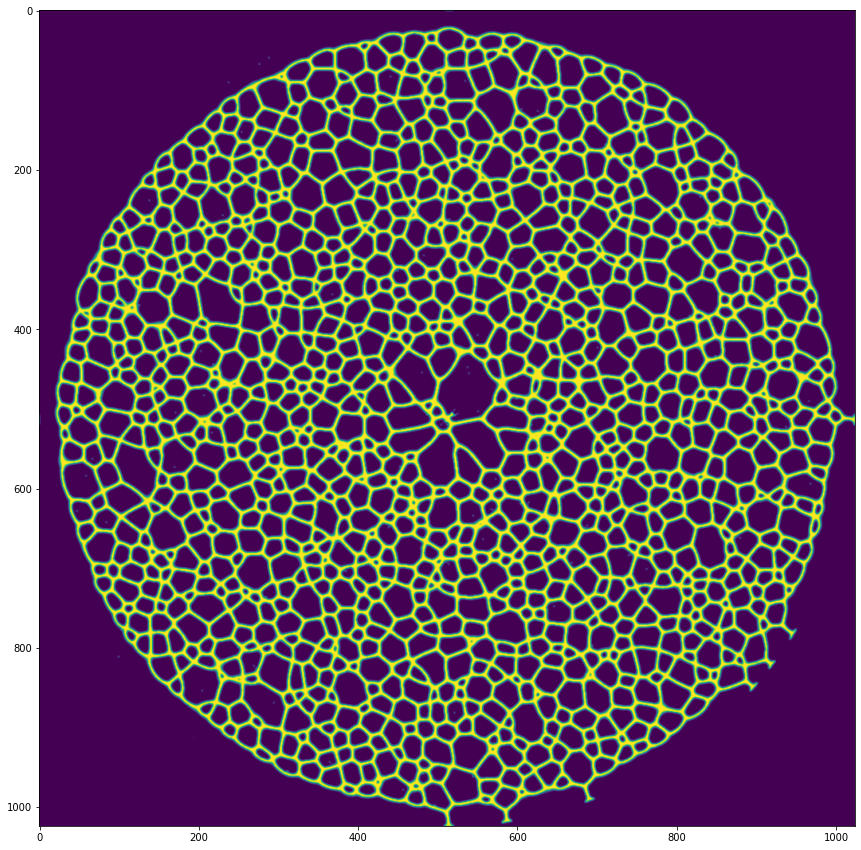

In [27]:
plt.figure(figsize=(15,15))
plt.imshow(full,vmax=iqr(full,rng=(0,95.)))

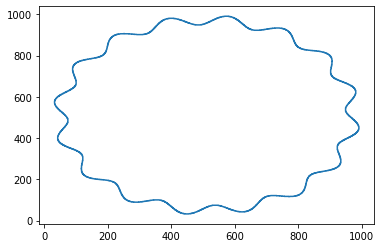

In [8]:
plt.plot(x_ring,y_ring)

In [1]:
import vispy
%gui qt5

In [9]:
import numpy as np
from vispy import app
from vispy.gloo import clear, set_clear_color, set_viewport, Program


# Image
def func(x, y):
    return (1-x/2+x**5+y**3)*np.exp(-x**2-y**2)
x = np.linspace(-3.0, 3.0, 512).astype(np.float32)
y = np.linspace(-3.0, 3.0, 512).astype(np.float32)
X, Y = np.meshgrid(x, y)
idxs = func(X, Y)

# Image normalization
vmin, vmax = idxs.min(), idxs.max()
idxs = (idxs - vmin) / (vmax - vmin)
idxs=grid.to_numpy()[0][:512,:512]

# Colormaps
colormaps = np.ones((16, 512, 4)).astype(np.float32)
values = np.linspace(0, 1, 512)[1:-1]

# Hot colormap
colormaps[0, 0] = 0, 0, 1, 1  # Low values  (< vmin)
colormaps[0, -1] = 0, 1, 0, 1  # High values (> vmax)
colormaps[0, 1:-1, 0] = np.interp(values, [0.00, 0.33, 0.66, 1.00],
                                          [0.00, 1.00, 1.00, 1.00])
colormaps[0, 1:-1, 1] = np.interp(values, [0.00, 0.33, 0.66, 1.00],
                                          [0.00, 0.00, 1.00, 1.00])
colormaps[0, 1:-1, 2] = np.interp(values, [0.00, 0.33, 0.66, 1.00],
                                          [0.00, 0.00, 0.00, 1.00])

# Grey colormap
colormaps[1, 0] = 0, 0, 1, 1  # Low values (< vmin)
colormaps[1, -1] = 0, 1, 0, 1  # High values (> vmax)
colormaps[1, 1:-1, 0] = np.interp(values, [0.00, 1.00],
                                          [0.00, 1.00])
colormaps[1, 1:-1, 1] = np.interp(values, [0.00, 1.00],
                                          [0.00, 1.00])
colormaps[1, 1:-1, 2] = np.interp(values, [0.00, 1.00],
                                          [0.00, 1.00])
# Jet colormap
# ...


img_vertex = """
attribute vec2 position;
attribute vec2 texcoord;
varying vec2 v_texcoord;
void main()
{
    gl_Position = vec4(position, 0.0, 1.0 );
    v_texcoord = texcoord;
}
"""

img_fragment = """
uniform float vmin;
uniform float vmax;
uniform float cmap;
uniform sampler2D image;
uniform sampler2D colormaps;
uniform vec2 colormaps_shape;
varying vec2 v_texcoord;
void main()
{
    float value = texture2D(image, v_texcoord).r;
    float index = (cmap+0.5) / colormaps_shape.y;
    if( value < vmin ) {
        gl_FragColor = texture2D(colormaps, vec2(0.0,index));
    } else if( value > vmax ) {
        gl_FragColor = texture2D(colormaps, vec2(1.0,index));
    } else {
        value = (value-vmin)/(vmax-vmin);
        value = 1.0/512.0 + 510.0/512.0*value;
        gl_FragColor = texture2D(colormaps, vec2(value,index));
    }
}
"""


class Canvas(app.Canvas):
    def __init__(self):
        app.Canvas.__init__(self, size=(512, 512),
                            keys='interactive')
        self.image = Program(img_vertex, img_fragment, 4)
        self.image['position'] = (-1, -1), (-1, +1), (+1, -1), (+1, +1)
        self.image['texcoord'] = (0, 0), (0, +1), (+1, 0), (+1, +1)
        self.image['vmin'] = +0.1
        self.image['vmax'] = +0.9
        self.image['cmap'] = 0  # Colormap index to use

        self.image['colormaps'] = colormaps
        self.image['colormaps'].interpolation = 'linear'
        self.image['colormaps_shape'] = colormaps.shape[1], colormaps.shape[0]

        self.image['image'] = idxs.astype('float32')
        self.image['image'].interpolation = 'linear'

        set_clear_color('black')

        self.show()

    def on_resize(self, event):
        width, height = event.physical_size
        set_viewport(0, 0, *event.physical_size)

    def on_draw(self, event):
        clear(color=True, depth=True)
        self.image.draw('triangle_strip')

if __name__ == '__main__':
    canvas = Canvas()
    app.run()

In [86]:
ti.random(53)

ValueError: Invalid data type 53